In [29]:
# -*- coding: utf-8 -*-
# @ Time    : 2024/10/06
# @ Author : zlz.bit.pro@gmail.com
# @ Desc: Example to determine the insert operations in different drfit setting in 

# set workspace to the root of the project
import os
workspace_path = '../..'
os.chdir(workspace_path)
print("Current workspace:", os.getcwd())

Current workspace: /users


In [30]:
import numpy as np
from neuralbench.index.util import load_key_set, KeyType, save_file
from neuralbench.index.bench import KeySetBinEncoder, sample_bulkloading_keyset
from neuralbench.drift import find_q

In [31]:
# load fb_200M_uint64 key set
keyset_file_path = "/users/lingze/TLI/data/fb_200M_uint64"
data = load_key_set(keyset_file_path)

In [32]:
# get data type and check whether unique
data_type = KeyType.resolve_type_from_filename(keyset_file_path)
print(data_type)
# flag = len(np.unique(data)) == len(data)
# print("Data is unique:", flag)

KeyType.UINT64


Max value: 18446744073709551615
Min value: 1


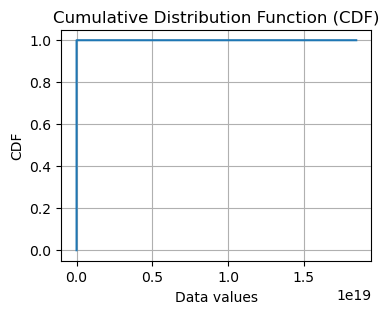

In [6]:
"""plot the data Cumulative Distribution Function (CDF)
"""
max_value = np.max(data)
min_value = np.min(data)
print("Max value:", max_value)
print("Min value:", min_value)
KeySetBinEncoder.plot_cdf(
    data,
    min_value=min_value,
    max_value=max_value,
)

In [33]:
"""abnormal key filter
# before we get the data distribution of key set
# we need to filter out the abnormal keys
"""
keys, removed_key = KeySetBinEncoder.filter_abnormal_values(data, "IQR", verbose = True)
print("Remove rate:", len(removed_key) / len(data))

Filtered 21 values, [199999979 / 200000000]
Remove rate: 1.05e-07


Total number of bins: 288


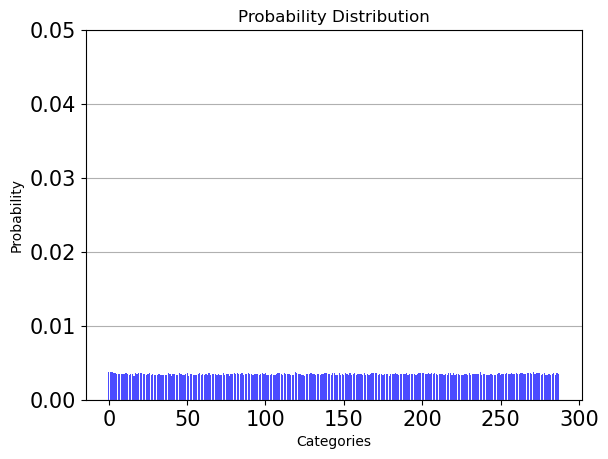

In [34]:
"""Bin the key set, get the distribution of key set
heuristically choose the bin size.
"""
bin_width_offset = 28
bin_idxs, prob, bin_idx_to_keys = KeySetBinEncoder.bin_keyset_to_distribution(
    keys,
    bin_width_offset=bin_width_offset,
    verbose=True
)
KeySetBinEncoder.plot_probability_distribution(prob, bin_idxs.tolist())

In [35]:
from collections import defaultdict

min_bin_num = int(np.min(bin_idxs))
max_bin_num = int(np.max(bin_idxs))
prob_dict = defaultdict(float)

for i, idx in enumerate(bin_idxs):
    prob_dict[idx] = prob[i]

x = [ i for i in range(min_bin_num, max_bin_num+1)]
y = [ prob_dict[i] if i in prob_dict else 0.0 for i in range(min_bin_num, max_bin_num+1) ]

0.02


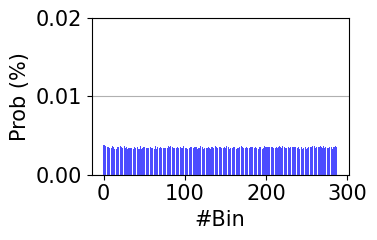

In [36]:
# draw the estimated distribution and store the figure
import matplotlib.pyplot as plt
labels = x
max_value = max(y)
rounded_max_value = np.ceil(max_value * 50) / 50
# rounded 0.05
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.bar(labels, y, color='blue', alpha=0.7)
ax.set_xlabel('#Bin', fontsize = 15)
ax.set_ylabel('Prob (%)', fontsize = 15)
# ax.set_title('Empirical Probability Distribution', fontsize = 15)
print(rounded_max_value)
ax.set_ylim(0, rounded_max_value)  # Set y-axis limits from 0 to 1
ax.grid(axis='y')
fig.tight_layout()
filepath = "/users/lingze/neurbench/data/keys/fb_200M_uint64_distribution.pdf"
fig.savefig(filepath, dpi = 800, bbox_inches = 'tight', pad_inches=0)
# Show the plot
fig.show()

---
### Drift 0.1

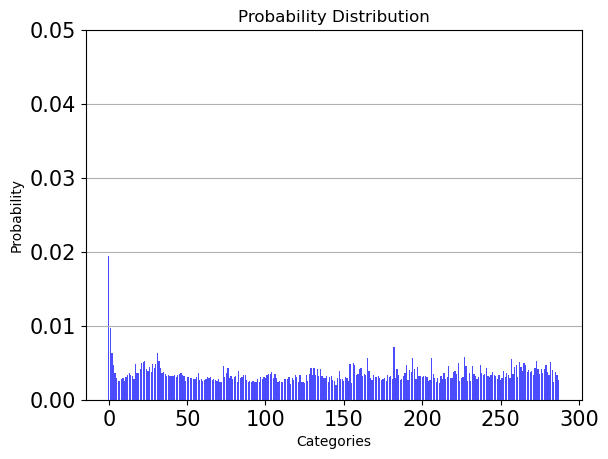

In [9]:
# Drift setting alpha = 0.1, unform drift
init_prob = find_q(prob, 0.1, skewed=True)
KeySetBinEncoder.plot_probability_distribution(init_prob)

In [10]:
bulkloading_n = int(0.5 * len(keys))
bulkloading_keys = sample_bulkloading_keyset(
    bin_idxs,
    init_prob,
    bin_idx_to_keys,
    bulkloading_n,
    verbose=True
)
print(len(bulkloading_keys)) 
print("Bulkloading key set size:", len(bulkloading_keys) / len(keys))

Exceeding the number of keys in bin 0, sample_n: 1942296, bound_n: 751421
Exceeding the number of keys in bin 1, sample_n: 971274, bound_n: 749333
Exceeding the number of keys in bin 182, sample_n: 708968, bound_n: 707472
Exceeding bins: 3 / 288
98585540
Bulkloading key set size: 0.49292775175741393


Total number of bins: 288


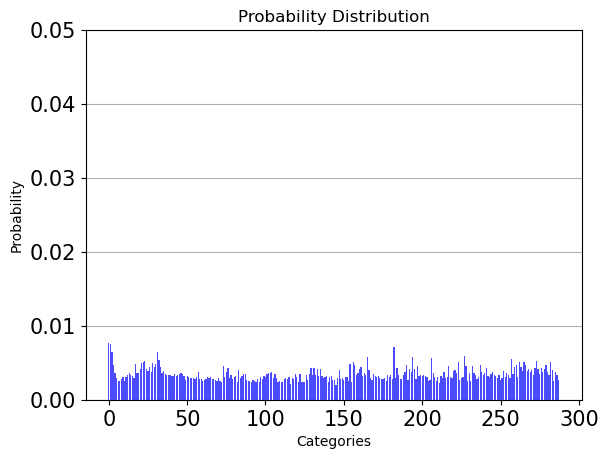

In [11]:
"""Bin the key set, get the distribution of key set
heuristically choose the bin size.
"""
bin_width_offset = 28
bin_idxs, ini_prob, _ = KeySetBinEncoder.bin_keyset_to_distribution(
    np.array(bulkloading_keys),
    bin_width_offset=bin_width_offset,
    verbose=True
)
KeySetBinEncoder.plot_probability_distribution(ini_prob)

In [16]:
inserted_keys = np.setdiff1d(data, bulkloading_keys)
print("Insert number of records:", len(inserted_keys))
print("Insert ratio:", len(inserted_keys) / len(data))
# print bulkloading key CDF

Insert number of records: 101414460
Insert ratio: 0.5070723


In [16]:
workload_dir_path = "/users/lingze/neurbench/data/workload/fb_200M_uint64_drift_01"
os.makedirs(workload_dir_path, exist_ok=True)

inserted_keys = np.array(inserted_keys, dtype=data_type.to_numpy_type())
bulkloading_keys = np.array(bulkloading_keys, dtype=data_type.to_numpy_type())

bulkloading_keyset_file_path = os.path.join(workload_dir_path, "init_keys_uint64")
insert_keyset_file_path = os.path.join(workload_dir_path, "insert_keys_uint64")
save_file(bulkloading_keyset_file_path, bulkloading_keys, data_type)
save_file(insert_keyset_file_path, inserted_keys, data_type)

In [12]:

# draw the picture of the bulkloading key 
prob_dict = defaultdict(float)
for i, idx in enumerate(bin_idxs):
    prob_dict[idx] = ini_prob[i]
y = [ prob_dict[i] if i in prob_dict else 0.0 for i in range(min_bin_num, max_bin_num+1) ]

0.02


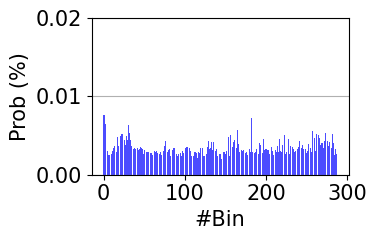

In [13]:
# draw the estimated distribution and store the figure
# draw the estimated distribution and store the figure
import matplotlib.pyplot as plt
labels = x
max_value = max(y)
rounded_max_value = np.ceil(max_value * 50) / 50
# rounded 0.05
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.bar(labels, y, color='blue', alpha=0.7)
ax.set_xlabel('#Bin', fontsize = 15)
ax.set_ylabel('Prob (%)', fontsize = 15)
print(rounded_max_value)
ax.set_ylim(0, rounded_max_value)  # Set y-axis limits from 0 to 1
ax.grid(axis='y')
fig.tight_layout()
filepath = "/users/lingze/neurbench/data/keys/fb_200M_uint64_distribution_drift_01.pdf"
fig.savefig(filepath, dpi = 800, bbox_inches = 'tight', pad_inches=0)
# Show the plot
fig.show()

---
### Drift 0.3

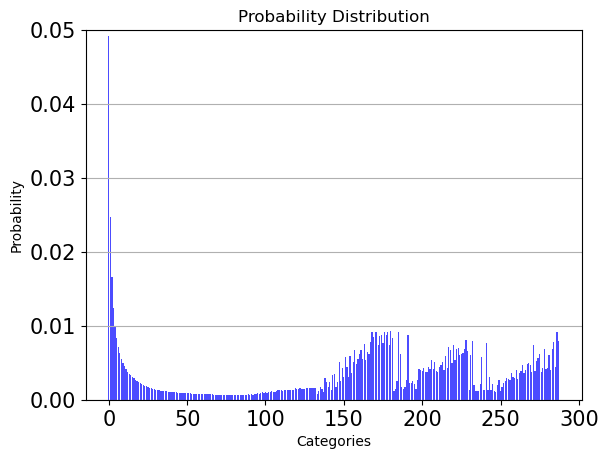

In [37]:
# Drift setting alpha = 0.2, unform drift
init_prob = find_q(prob, 0.3, skewed=True)
KeySetBinEncoder.plot_probability_distribution(init_prob)

In [38]:
bulkloading_n = int(0.6 * len(keys))
bulkloading_keys = sample_bulkloading_keyset(
    bin_idxs,
    init_prob,
    bin_idx_to_keys,
    bulkloading_n,
    verbose=True
)
print(len(bulkloading_keys)) 
print("Bulkloading key set size:", len(bulkloading_keys) / len(keys))
# print bulkloading key CDF
# KeySetBinEncoder.plot_cdf(
#     bulkloading_keys,
#     min_value=min_value,
#     max_value=max_value,
# )

Exceeding the number of keys in bin 0, sample_n: 5910431, bound_n: 751421
Exceeding the number of keys in bin 1, sample_n: 2967751, bound_n: 749333
Exceeding the number of keys in bin 2, sample_n: 1985238, bound_n: 741201
Exceeding the number of keys in bin 3, sample_n: 1492975, bound_n: 728502
Exceeding the number of keys in bin 4, sample_n: 1196839, bound_n: 719635
Exceeding the number of keys in bin 5, sample_n: 998938, bound_n: 705936
Exceeding the number of keys in bin 6, sample_n: 856827, bound_n: 708908
Exceeding the number of keys in bin 7, sample_n: 750459, bound_n: 682509
Exceeding the number of keys in bin 157, sample_n: 806801, bound_n: 724329
Exceeding the number of keys in bin 160, sample_n: 740811, bound_n: 698353
Exceeding the number of keys in bin 161, sample_n: 803260, bound_n: 705878
Exceeding the number of keys in bin 163, sample_n: 899692, bound_n: 715715
Exceeding the number of keys in bin 165, sample_n: 775053, bound_n: 683738
Exceeding the number of keys in bin 

In [79]:
inserted_keys = np.setdiff1d(data, bulkloading_keys)
print("Insert number of records:", len(inserted_keys))
print("Insert ratio:", len(inserted_keys) / len(data))
# print bulkloading key CDF
# KeySetBinEncoder.plot_cdf(
#     inserted_keys,
#     min_value=min_value,
#     max_value=max_value,
# )

Insert number of records: 99986809
Insert ratio: 0.4999340425003298


Total number of bins: 288


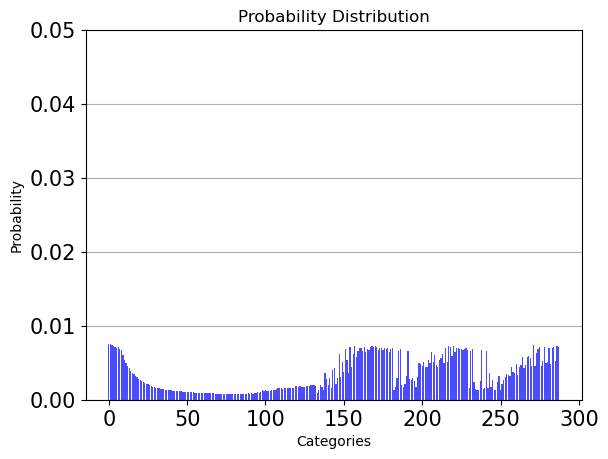

In [39]:
bin_width_offset = 28
bin_idxs, ini_prob, _ = KeySetBinEncoder.bin_keyset_to_distribution(
    np.array(bulkloading_keys),
    bin_width_offset=bin_width_offset,
    verbose=True
)
KeySetBinEncoder.plot_probability_distribution(ini_prob)

In [ ]:
workload_dir_path = "/users/lingze/neurbench/data/workload/fb_200M_uint64_drift_03"
os.makedirs(workload_dir_path, exist_ok=True)

inserted_keys = np.array(inserted_keys, dtype=data_type.to_numpy_type())
bulkloading_keys = np.array(bulkloading_keys, dtype=data_type.to_numpy_type())

bulkloading_keyset_file_path = os.path.join(workload_dir_path, "init_keys_uint64")
insert_keyset_file_path = os.path.join(workload_dir_path, "insert_keys_uint64")
save_file(bulkloading_keyset_file_path, bulkloading_keys, data_type)
save_file(insert_keyset_file_path, inserted_keys, data_type)

In [40]:
# draw the picture of the bulkloading key 
prob_dict = defaultdict(float)
for i, idx in enumerate(bin_idxs):
    prob_dict[idx] = ini_prob[i]
y = [ prob_dict[i] if i in prob_dict else 0.0 for i in range(min_bin_num, max_bin_num+1) ]


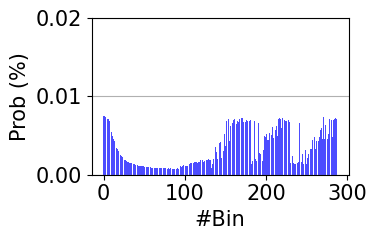

In [41]:
# draw the estimated distribution and store the figure
# draw the estimated distribution and store the figure
import matplotlib.pyplot as plt
labels = x
max_value = max(y)
rounded_max_value = np.ceil(max_value * 50) / 50
# rounded 0.05
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.bar(labels, y, color='blue', alpha=0.7)
ax.set_xlabel('#Bin', fontsize = 15)
ax.set_ylabel('Prob (%)', fontsize = 15)
ax.set_ylim(0, rounded_max_value)  # Set y-axis limits from 0 to 1
ax.grid(axis='y')
fig.tight_layout()
filepath = "/users/lingze/neurbench/data/keys/fb_200M_uint64_distribution_drift_03.pdf"
fig.savefig(filepath, dpi = 800, bbox_inches = 'tight', pad_inches=0)
# Show the plot
fig.show()

---
### Drift 0.5

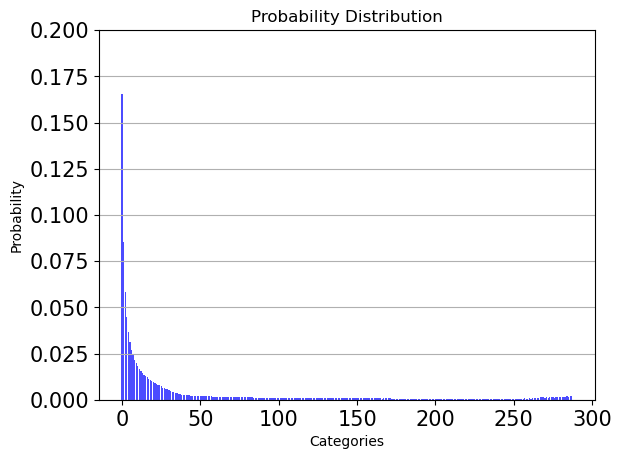

In [19]:
# Drift setting alpha = 0.2, unform drift
init_prob = find_q(prob, 0.5, skewed=True)
KeySetBinEncoder.plot_probability_distribution(init_prob)

In [20]:
bulkloading_n = int(0.8 * len(keys))
bulkloading_keys = sample_bulkloading_keyset(
    bin_idxs,
    init_prob,
    bin_idx_to_keys,
    bulkloading_n,
    verbose=True
)
print(len(bulkloading_keys)) 
print("Bulkloading key set size:", len(bulkloading_keys) / len(keys))

Exceeding the number of keys in bin 0, sample_n: 26474189, bound_n: 751421
Exceeding the number of keys in bin 1, sample_n: 13620689, bound_n: 749333
Exceeding the number of keys in bin 2, sample_n: 9314716, bound_n: 741201
Exceeding the number of keys in bin 3, sample_n: 7148108, bound_n: 728502
Exceeding the number of keys in bin 4, sample_n: 5837510, bound_n: 719635
Exceeding the number of keys in bin 5, sample_n: 4957293, bound_n: 705936
Exceeding the number of keys in bin 6, sample_n: 4318060, bound_n: 708908
Exceeding the number of keys in bin 7, sample_n: 3842165, bound_n: 682509
Exceeding the number of keys in bin 8, sample_n: 3452855, bound_n: 702091
Exceeding the number of keys in bin 9, sample_n: 3149007, bound_n: 685749
Exceeding the number of keys in bin 10, sample_n: 2888868, bound_n: 690347
Exceeding the number of keys in bin 11, sample_n: 2652130, bound_n: 725454
Exceeding the number of keys in bin 12, sample_n: 2477576, bound_n: 696262
Exceeding the number of keys in b

In [10]:
inserted_keys = np.setdiff1d(data, bulkloading_keys)
print("Insert number of records:", len(inserted_keys))
print("Insert ratio:", len(inserted_keys) / len(data))

Insert number of records: 134836178
Insert ratio: 0.6741808866290956


Total number of bins: 288


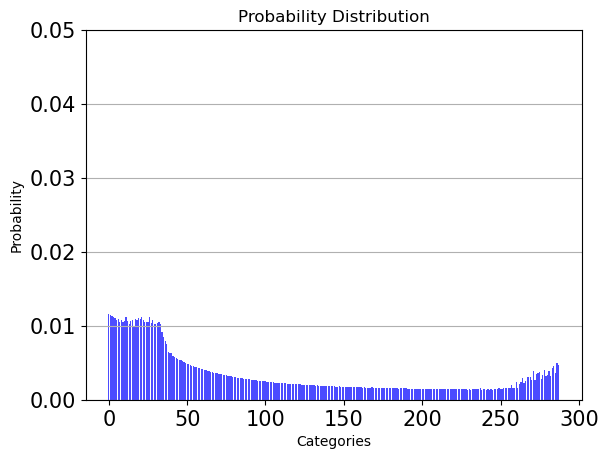

In [21]:
bin_width_offset = 28
bin_idxs, ini_prob, _ = KeySetBinEncoder.bin_keyset_to_distribution(
    np.array(bulkloading_keys),
    bin_width_offset=bin_width_offset,
    verbose=True
)
KeySetBinEncoder.plot_probability_distribution(ini_prob)

In [12]:
workload_dir_path = "/users/lingze/neurbench/data/workload/fb_200M_uint64_drift_05"
os.makedirs(workload_dir_path, exist_ok=True)

inserted_keys = np.array(inserted_keys, dtype=data_type.to_numpy_type())
bulkloading_keys = np.array(bulkloading_keys, dtype=data_type.to_numpy_type())

bulkloading_keyset_file_path = os.path.join(workload_dir_path, "init_keys_uint64")
insert_keyset_file_path = os.path.join(workload_dir_path, "insert_keys_uint64")
save_file(bulkloading_keyset_file_path, bulkloading_keys, data_type)
save_file(insert_keyset_file_path, inserted_keys, data_type)

In [22]:
# draw the picture of the bulkloading key 
prob_dict = defaultdict(float)
for i, idx in enumerate(bin_idxs):
    prob_dict[idx] = ini_prob[i]
y = [ prob_dict[i] if i in prob_dict else 0.0 for i in range(min_bin_num, max_bin_num+1) ]

0.02


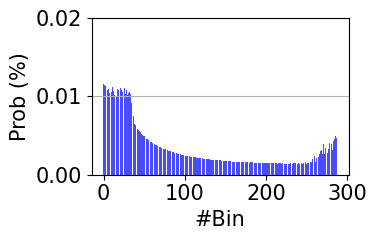

In [23]:
# draw the estimated distribution and store the figure
import matplotlib.pyplot as plt
labels = x
max_value = max(y)
rounded_max_value = np.ceil(max_value * 50) / 50
# rounded 0.05
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.bar(labels, y, color='blue', alpha=0.7)
ax.set_xlabel('#Bin', fontsize = 15)
ax.set_ylabel('Prob (%)', fontsize = 15)
print(rounded_max_value)
ax.set_ylim(0, rounded_max_value)  # Set y-axis limits from 0 to 1
ax.grid(axis='y')
fig.tight_layout()
filepath = "/users/lingze/neurbench/data/keys/fb_200M_uint64_distribution_drift_05.pdf"
fig.savefig(filepath, dpi = 800, bbox_inches = 'tight', pad_inches=0)
# Show the plot
fig.show()

---
### Drift 0.7

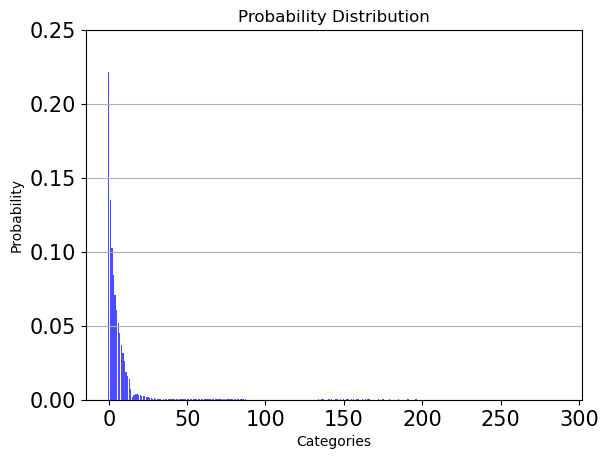

In [24]:
# Drift setting alpha = 0.7, unform drift
init_prob = find_q(prob, 0.7, skewed=True)
KeySetBinEncoder.plot_probability_distribution(init_prob)

In [25]:
bulkloading_n = int(len(keys))
bulkloading_keys = sample_bulkloading_keyset(
    bin_idxs,
    init_prob,
    bin_idx_to_keys,
    bulkloading_n,
    verbose=True
)
print(len(bulkloading_keys)) 
print("Bulkloading key set size:", len(bulkloading_keys) / len(keys))

Exceeding the number of keys in bin 0, sample_n: 44311079, bound_n: 751421
Exceeding the number of keys in bin 1, sample_n: 27077948, bound_n: 749333
Exceeding the number of keys in bin 2, sample_n: 20586768, bound_n: 741201
Exceeding the number of keys in bin 3, sample_n: 16842916, bound_n: 728502
Exceeding the number of keys in bin 4, sample_n: 14197686, bound_n: 719635
Exceeding the number of keys in bin 5, sample_n: 12175791, bound_n: 705936
Exceeding the number of keys in bin 6, sample_n: 10346288, bound_n: 708908
Exceeding the number of keys in bin 7, sample_n: 9055784, bound_n: 682509
Exceeding the number of keys in bin 8, sample_n: 7395424, bound_n: 702091
Exceeding the number of keys in bin 9, sample_n: 6353619, bound_n: 685749
Exceeding the number of keys in bin 10, sample_n: 5229781, bound_n: 690347
Exceeding the number of keys in bin 11, sample_n: 3777805, bound_n: 725454
Exceeding the number of keys in bin 12, sample_n: 3223470, bound_n: 696262
Exceeding the number of keys

In [64]:
inserted_keys = np.setdiff1d(data, bulkloading_keys)
print("Insert number of records:", len(inserted_keys))
print("Insert ratio:", len(inserted_keys) / len(data))

Insert number of records: 174277116
Insert ratio: 0.8713855756430722


Total number of bins: 288


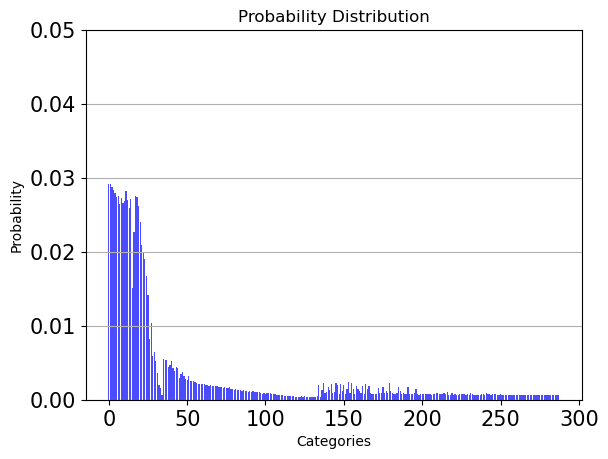

In [26]:
bin_width_offset = 28
bin_idxs, ini_prob, _ = KeySetBinEncoder.bin_keyset_to_distribution(
    np.array(bulkloading_keys),
    bin_width_offset=bin_width_offset,
    verbose=True
)
KeySetBinEncoder.plot_probability_distribution(ini_prob)

In [23]:
workload_dir_path = "/users/lingze/neurbench/data/workload/fb_200M_uint64_drift_07"
os.makedirs(workload_dir_path, exist_ok=True)

inserted_keys = np.array(inserted_keys, dtype=data_type.to_numpy_type())
bulkloading_keys = np.array(bulkloading_keys, dtype=data_type.to_numpy_type())

bulkloading_keyset_file_path = os.path.join(workload_dir_path, "init_keys_uint64")
insert_keyset_file_path = os.path.join(workload_dir_path, "insert_keys_uint64")
save_file(bulkloading_keyset_file_path, bulkloading_keys, data_type)
save_file(insert_keyset_file_path, inserted_keys, data_type)

In [27]:
# draw the picture of the bulkloading key 
prob_dict = defaultdict(float)
for i, idx in enumerate(bin_idxs):
    prob_dict[idx] = ini_prob[i]
y = [ prob_dict[i] if i in prob_dict else 0.0 for i in range(min_bin_num, max_bin_num+1) ]

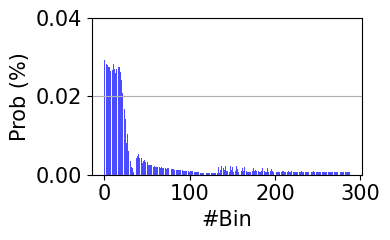

In [28]:
# draw the estimated distribution and store the figure
import matplotlib.pyplot as plt
labels = x
max_value = max(y)
rounded_max_value = np.ceil(max_value * 50) / 50
# rounded 0.05
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.bar(labels, y, color='blue', alpha=0.7)
ax.set_xlabel('#Bin', fontsize = 15)
ax.set_ylabel('Prob (%)', fontsize = 15)
ax.set_ylim(0, rounded_max_value)  # Set y-axis limits from 0 to 1
ax.grid(axis='y')
fig.tight_layout()
filepath = "/users/lingze/neurbench/data/keys/fb_200M_uint64_distribution_drift_07.pdf"
fig.savefig(filepath, dpi = 800, bbox_inches = 'tight', pad_inches=0)
# Show the plot
fig.show()